# Introduction

In this exercise we will conduct exploratory data analysis on the results of a poll titled "What do Greeks believe" ([dianeosis, 2022](https://www.dianeosis.org/research/ti-pistevoyn-oi-ellines-2022/)).

Some questions we will try to answer in the process are:
* What are some correlated beliefs in the Greek populace?
* Which beliefs are most affected by political ideology in particular?
* What are the main beliefs that are going to become mainstream as the younger generation gets older?

# Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from itertools import groupby
%matplotlib inline

First we will load the data and fix a couple of issues.

In [ ]:
raw_data=pd.read_csv('/content/raw_data.csv')

In [ ]:
raw_data.index=raw_data['id']
raw_data=raw_data.drop('id',axis=1)
raw_data=raw_data.sort_index()

In [ ]:
raw_data['D02a']=raw_data['D02a'].apply(lambda x: int(x) if str.isnumeric(x) else np.nan)
raw_data['D02a']=raw_data['D02a'].apply(lambda x: 2022-x if x>1900 else x)
raw_data.rename(columns={'PER':'D08'}, inplace=True)

And we will drop some of the columns we won't be using:

In [ ]:
raw_data=raw_data.drop(['row','sta2','nuts'],axis=1)
raw_data.drop(['D02','D04','D08','D09','Q29'],axis=1,inplace=True)
for col in ['Q08','Q24','Q28','Q32']:
    raw_data.drop([i for i in raw_data.columns if col in i],axis=1,inplace=True)

## Questionnaire

We will also load the text of the questionnaire and put the questions in a dictionary, to make it easier to look up what each column represents.

In [ ]:
with open('/content/qnaire.txt','r') as f:
    l=f.readlines()

pars = [list(g) for _, g in groupby(l, key='\n'.__ne__)]
pars2=[i for i in pars if '\n' not in i]
pars3=pars2[1:53]
pars3.remove(['ΔΗΜΟΓΡΑΦΙΚΑ ΧΑΡΑΚΤΗΡΙΣΤΙΚΑ\n'])

In [ ]:
q=dict()
q['D01']=pars3[0][0].strip()
q['D02']=pars3[1][0].strip()
q['D02a']=pars3[2][0].strip()
q['D03']=pars3[44][0].strip()
q['D04']=pars3[3][0].strip()
for i in range(5,11):
    q['D{:02}'.format(i)]=pars3[i+40][0].strip()
subqs={5:4,12:7,17:8,21:3}
for i in range(1,41):
    q['Q{:02}'.format(i)]=pars3[i+3][0].strip()
    if i in subqs:
        for j in range(1,subqs[i]+1):
            q['Q{:02}_{}'.format(i,j)]=pars3[i+3][j if i<17 else j+1].strip()

In [ ]:
def give_qna():
    for i in raw_data.columns:
        if i not in q:
            continue

        u_a = pd.unique(raw_data[i])

        if len(u_a)>15:
            yield str(q[i])+'\n'+f'<{len(u_a)} different answers>'
            continue
        yield str(q[i])+'\n'+str(list(u_a))

In [ ]:
for i in give_qna():
    print(i)

D1) Φύλο
['Άνδρας', 'Γυναίκα']
D2a) Ηλικία (σε χρόνια)
<75 different answers>
2) Η Ελλάδα συμπλήρωσε 42 χρόνια από την ένταξή της στην Ευρωπαϊκή Κοινότητα. Θεωρείτε ότι η συνολική αποτίμηση από τη συμμετοχή της χώρας στην ΕΕ είναι…
['Μάλλον θετική', 'Μάλλον αρνητική', 'Θετική', 'Αρνητική', 'ΔΞ/ΔΑ', nan]
3) Φέτος συμπληρώνονται 20 χρόνια από την είσοδο της Ελλάδας στη ζώνη του ευρώ. Κατά τη γνώμη σας το να συμμετάσχουμε στο ευρώ ήταν μια σωστή ή λάθος απόφαση;
['Μάλλον σωστή', 'Λάθος', 'Σωστή', 'Μάλλον λάθος', 'ΔΞ/ΔΑ', nan]
4) Και με ποια από τις παρακάτω φράσεις συμφωνείτε περισσότερο;
['Η Ευρωπαϊκή Ένωση έχει δομές και εκφράζει συμφέροντα που δεν εξυπ', 'Η Ευρωπαϊκή Ένωση αποτελεί πρόοδο και είναι αναγκαία η παραμονή τ', 'ΔΞ/ΔΑ', nan]
• Υγεία
['ΝΑΙ', 'ΟΧΙ', 'ΔΞ/ΔΑ', nan]
• Άμυνα
['ΝΑΙ', 'ΔΞ/ΔΑ', 'ΟΧΙ', nan]
• Εξωτερική πολιτική
['ΝΑΙ', 'ΔΞ/ΔΑ', 'ΟΧΙ', nan]
• Παιδεία
['ΝΑΙ', 'ΟΧΙ', 'ΔΞ/ΔΑ', nan]
6) Πιστεύετε ότι ο ρόλος της Ευρωπαϊκής Ένωσης στο θέμα της αντιμετώπισης της πανδημίας ήτα

## Turn ordinal features into numerical

For the first part, we will convert all features that follow a logical order but are represented in text, such as questions asking for level of agreement, into numerals. We will also convert binary questions (yes/no, good/bad) into 1 and 0.

In [ ]:
data=raw_data.replace(['ΔΞ/ΔΑ','ΟΧΙ','ΝΑΙ','Όχι', 'Ναι','κακό','καλό'],[None,0,1,0,1,0,1])
data=data.replace(['Άνδρας','Γυναίκα'],[0,1])
data=data.replace(['συμφωνώ', 'μάλλον συμφωνώ', 'μάλλον διαφωνώ', 'διαφωνώ'],[3,2,1,0])
data['Q02']=data['Q02'].replace(['Αρνητική', 'ΔΞ/ΔΑ', 'Θετική', 'Μάλλον αρνητική', 'Μάλλον θετική'],[0,None,3,1,2])
data['Q03']=data['Q03'].replace(['ΔΞ/ΔΑ', 'Λάθος', 'Μάλλον λάθος', 'Μάλλον σωστή', 'Σωστή'],[None,0,1,2,3])
data['Q04']=data['Q04'].replace(['Η Ευρωπαϊκή Ένωση αποτελεί πρόοδο και είναι αναγκαία η παραμονή τ','Η Ευρωπαϊκή Ένωση έχει δομές και εκφράζει συμφέροντα που δεν εξυπ'],[1,0])
data['Q06']=data['Q06'].replace(['Θετικός', 'Μάλλον αρνητικός', 'Μάλλον θετικός', 'Αρνητικός'],[3,1,2,0])
data['Q07']=data['Q07'].replace(['Θα διασπαστεί, με κάποιες χώρες να αποχωρούν', 'Θα συνεχίσει να υπάρχει με τη μορφή που έχει σήμερα', 'Θα γίνει μια πιο ενωμένη ομοσπονδία κρατών', 'Θα διαλυθεί'],[1,2,3,0])
data['Q11']=data['Q11'].replace(['Όχι, αλλά θα την επηρεάσει αρνητικά στο μέλλον','Όχι, και δεν θα την επηρεάσει αρνητικά στο μέλλον', 'Ναι, την επηρεάζει αρνητικά σήμερα'],[1,0,2])
data['Q13']=data['Q13'].replace(['Μάλλον θετική', 'Αρνητική', 'Μάλλον αρνητική', 'Θετική'],[2,0,1,3])
data['Q14']=data['Q14'].replace(['Μέσα στο 2023', 'Μέχρι το καλοκαίρι', 'Μέχρι το τέλος του 2022', 'Αργότερα', 'Το επόμενο δίμηνο'],[1,3,2,0,4])
data['Q15']=data['Q15'].replace(['Θετική', 'Αρνητική', 'Θετική με επιφυλάξεις'],[2,0,1])
data['Q16']=data['Q16'].replace(['Ναι', 'Όχι και δεν θα το κάνω', 'Όχι γιατί έχω νοσήσει', 'Όχι, αλλά προγραμματίζω/σκέφτομαι να το κάνω'],[3,0,1,2])
data['Q18']=data['Q18'].replace(['Πιο αυστηρή', 'Αυτή που είναι σήμερα', 'Λιγότερο αυστηρή'],[0,1,2])
data['Q19']=data['Q19'].replace(['Να παραμείνουν προσωρινά σε κέντρα κράτησης ώστε να προωθηθούν έ', 'Άμεση απέλαση', 'Προώθηση στη χώρα επιλογής τους', 'Να ενσωματωθούν σταδιακά υπό προϋποθέσεις', 'Να ενσωματωθούν πλήρως στην Ελληνική κοινωνία'],[1,0,2,3,4])
data['Q20']=data['Q20'].replace(['Ναι, σωστό', 'Όχι, λάθος'],[1,0])
data['Q22']=data['Q22'].replace(['Πολύ', 'Λίγο', 'Αρκετά', 'Καθόλου'],[3,1,2,0])
data['Q25']=data['Q25'].replace(['Όπως και πριν, αλλά  αναδεικνύονται περισσότερο', 'Υπάρχει αυξανόμενη τάση'],[0,1])
data['Q27']=data['Q27'].replace(['Συμφωνώ', 'Μάλλον συμφωνώ', 'Διαφωνώ', 'Μάλλον διαφωνώ'],[3,2,0,1])
data['Q30']=data['Q30'].replace(['Ένα', 'Κανένα', 'Δύο', 'Τρία', 'Τέσσερα', 'Πέντε', 'Περισσότερα από 5'],[1,0,2,3,4,5,6])
data['Q31']=data['Q31'].replace(['Ένα', 'Κανένα', 'Δύο', 'Τρία', 'Τέσσερα', 'Πέντε', 'Περισσότερα από 5'],[1,0,2,3,4,5,6])
data['Q34']=data['Q34'].replace(['6', '8', '10 «πολύ κοντά στην Θρησκεία»', '1 «πολύ μακριά από την θρησκεία»', '4', '3', '7', '5', '9', '2'],[6,8,10,1,4,3,7,5,9,2])
data['Q35']=data['Q35'].replace(['Η επιστήμη', 'Και οι δύο εξίσου (αυθ.)', 'Κανένας από τους δύο (αυθ.)', 'ΔΞ/ΔΑ (αυθ.)', 'Η θρησκεία'],[0,1,1,None,2])
data['Q36']=data['Q36'].replace(['1-2 φορές το χρόνο', 'Κάθε εβδομάδα ή συχνότερα', '1-2 φορές το μήνα', 'Ποτέ', 'Λιγότερο συχνά'],[2,4,3,0,1])
data['Q37']=data['Q37'].replace(['Από το δημόσιο', 'Από πόρους της Εκκλησίας'],[1,0])
data['Q39']=data['Q39'].replace(['Δεξιά', 'Κεντροδεξιά', 'Δεν με εκφράζει ο άξονας (ΔΕΝ ΔΙΑΒΑΖΟΥΜΕ)', 'Κεντροαριστερά', 'Κέντρο', 'Αριστερά', 'Άκρα δεξιά', 'Άκρα αριστερά'],[5,4,None,2,3,1,6,0])
data['D03']=data['D03'].replace(['Απόφοιτος Λυκείου', 'Απόφοιτος Τεχνικής εκπαίδευσης – ΙΕΚ', 'Κάτοχος μεταπτυχιακού ή διδακτορικού τίτλου', 'Απόφοιτος ΤΕΙ/ ΑΕΙ', 'Απόφοιτος Δημοτικού', 'Απόφοιτος Γυμνασίου', 'Δεν αποφοίτησα από το Δημοτικό'],[3,4,6,5,1,2,0])
data['D05']=data['D05'].replace(['1.501-2.000 ευρώ το μήνα', '1.001-1.500 ευρώ το μήνα', '2.001-3.000 ευρώ το μήνα', 'Κάτω από 500 ευρώ το μήνα', '501-1.000 ευρώ το μήνα', '3.001-5.000 ευρώ το μήνα', 'Πάνω από 5.000 ευρώ το μήνα'],[3,2,4,0,1,5,6])
data['D06']=data['D06'].replace(['Τα βγάζω πέρα αλλά δεν μπορώ να αποταμιεύσω', 'Τα βγάζω πέρα με πολύ μεγάλες δυσκολίες', 'Είμαι σχετικά άνετος οικονομικά', 'Δεν τα βγάζω πέρα'],[2,1,3,0])
data['D07']=data['D07'].replace(['Μεσαία', 'Μέση ανώτερη', 'Μέση κατώτερη', 'Κατώτερη', 'Ανώτερη'],[2,3,1,0,4])
data['D10']=data['D10'].replace(['Αστική (Πόλη άνω των 10.000)', 'Αγροτική περιοχή (έως 2.000)', 'Ημιαστική (2.000 έως 10.000)'],[2,0,1])

# Visualization

Now that most features are numerical, we can use their correlation matrix turned into a heatmap to get a feel of the relationships between them.

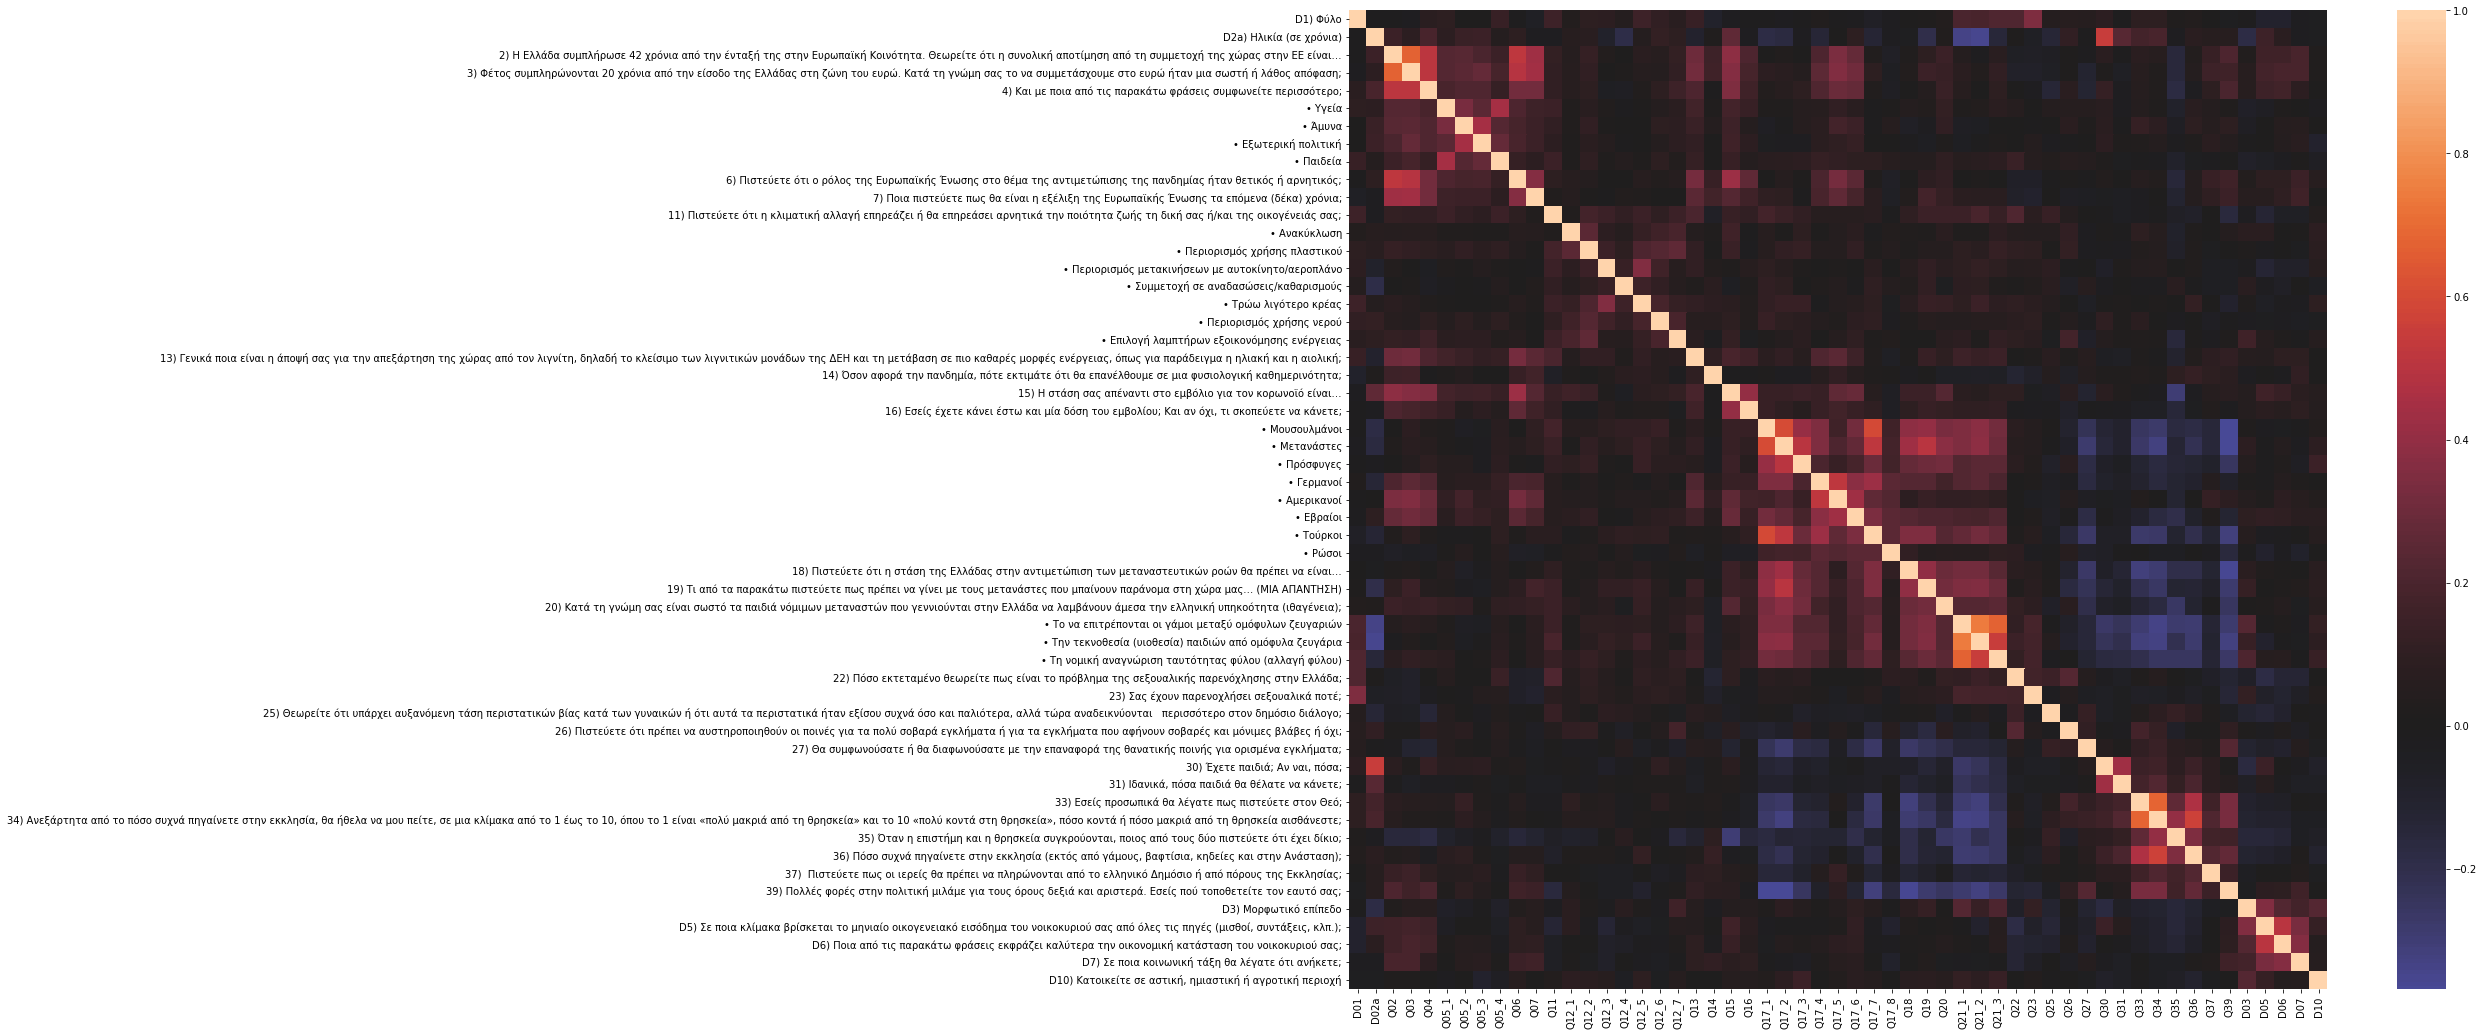

In [ ]:
plt.figure(figsize=(25,18))
#mask=np.triu(np.ones((54,54)),k=1)
corr_matrix=data.corr()
corr_matrix.index=[q[i] for i in corr_matrix.index]
sns.heatmap(corr_matrix,square=True,center=0)

Interesting! By looking at the area around the diagonal line, we can make out the squares formed by the fact that questions in the poll are grouped together by subject.
These are, vaguely:
* the EU Block (Q02-Q07), higher values designate a more positive attitude towards the European Union
* the Green Block (Q11-Q13), higher values designate a more positive attitude towards environmentalism
* the Covid Block (Q15-Q16), higher values designate a more positive attitude towards the COVID-19 vaccine
* the Xenophobic Block (Q17-Q21), higher values designate a more positive attitude towards refugees and foreigners, also contains:
* the Gay Block (Q21) higher values designate a more positive attitude towards gender and sexual minorities
* the God Block (Q33-Q38), higher values designate a more positive attitude towards religion and the Church, but also right-wing beliefs
* the Rich Block (D03-D07), higher values designate a higher economic status, but also level of education

We can also see relationships between different areas, such as positive EU sentiment being correlated with being in favour of shutting down coal plants, trusting the vaccine and liking Germans, Americans and Jews, or higher religiosity being negatively correlated with positive sentiment for foreigners and minorities.

Now that we have a glimpse of overall insight from the correlation matrix, we will focus on a subset of the questions, some representing the broad subjects of the poll and some I found interesting. It is no longer useful to have the answers represented as numeric values, but we will convert answers representing level of agreement into emoticons as a visual aid (and because it's fun).

In [ ]:
data=raw_data.copy()
data['Q33']=data['Q33'].replace(['Ναι','Όχι','ΔΞ/ΔΑ'],['😇','😈',None])
data=data.replace(['ΔΞ/ΔΑ','ΟΧΙ','ΝΑΙ','Όχι', 'Ναι','κακό','καλό'],['😶','☹','☺','☹','☺','☹','☺'])
data=data.replace(['διαφωνώ', 'μάλλον διαφωνώ', 'μάλλον συμφωνώ', 'συμφωνώ'],['😣','☹','☺','😃'])
data['Q02']=data['Q02'].replace(['Αρνητική', 'Μάλλον αρνητική', 'Μάλλον θετική', 'Θετική'],['😣','☹','☺','😃'])
data['Q03']=data['Q03'].replace(['ΔΞ/ΔΑ', 'Λάθος', 'Μάλλον λάθος', 'Μάλλον σωστή', 'Σωστή'],[None,0,1,2,3])
data['Q04']=data['Q04'].replace(['Η Ευρωπαϊκή Ένωση αποτελεί πρόοδο και είναι αναγκαία η παραμονή τ','Η Ευρωπαϊκή Ένωση έχει δομές και εκφράζει συμφέροντα που δεν εξυπ'],[1,0])
data['Q06']=data['Q06'].replace(['Θετικός', 'Μάλλον αρνητικός', 'Μάλλον θετικός', 'Αρνητικός'],[3,1,2,0])
data['Q07']=data['Q07'].replace(['Θα διασπαστεί, με κάποιες χώρες να αποχωρούν', 'Θα συνεχίσει να υπάρχει με τη μορφή που έχει σήμερα', 'Θα γίνει μια πιο ενωμένη ομοσπονδία κρατών', 'Θα διαλυθεί'],[1,2,3,0])
data['Q11']=data['Q11'].replace(['Όχι, αλλά θα την επηρεάσει αρνητικά στο μέλλον','Όχι, και δεν θα την επηρεάσει αρνητικά στο μέλλον', 'Ναι, την επηρεάζει αρνητικά σήμερα'],['☹','☺','😣'])
data['Q13']=data['Q13'].replace(['Μάλλον θετική', 'Αρνητική', 'Μάλλον αρνητική', 'Θετική'],[2,0,1,3])
data['Q14']=data['Q14'].replace(['Μέσα στο 2023', 'Μέχρι το καλοκαίρι', 'Μέχρι το τέλος του 2022', 'Αργότερα', 'Το επόμενο δίμηνο'],[1,3,2,0,4])
data['Q15']=data['Q15'].replace(['Θετική', 'Αρνητική', 'Θετική με επιφυλάξεις'],['☺','😣','☹'])
data['Q16']=data['Q16'].replace(['Ναι', 'Όχι και δεν θα το κάνω', 'Όχι γιατί έχω νοσήσει', 'Όχι, αλλά προγραμματίζω/σκέφτομαι να το κάνω'],[3,0,1,2])
data['Q18']=data['Q18'].replace(['Πιο αυστηρή', 'Αυτή που είναι σήμερα', 'Λιγότερο αυστηρή'],[0,1,2])
data['Q19']=data['Q19'].replace(['Να παραμείνουν προσωρινά σε κέντρα κράτησης ώστε να προωθηθούν έ', 'Άμεση απέλαση', 'Προώθηση στη χώρα επιλογής τους', 'Να ενσωματωθούν σταδιακά υπό προϋποθέσεις', 'Να ενσωματωθούν πλήρως στην Ελληνική κοινωνία'],[1,0,2,3,4])
data['Q20']=data['Q20'].replace(['Ναι, σωστό', 'Όχι, λάθος'],[1,0])
data['Q22']=data['Q22'].replace(['Πολύ', 'Λίγο', 'Αρκετά', 'Καθόλου'],[3,1,2,0])
data['Q25']=data['Q25'].replace(['Όπως και πριν, αλλά  αναδεικνύονται περισσότερο', 'Υπάρχει αυξανόμενη τάση'],[0,1])
data['Q27']=data['Q27'].replace(['Συμφωνώ', 'Μάλλον συμφωνώ', 'Διαφωνώ', 'Μάλλον διαφωνώ'],['😃','☺','😣','☹'])
data['Q30']=data['Q30'].replace(['Ένα', 'Κανένα', 'Δύο', 'Τρία', 'Τέσσερα', 'Πέντε', 'Περισσότερα από 5'],[1,0,2,3,4,5,6])
data['Q31']=data['Q31'].replace(['Ένα', 'Κανένα', 'Δύο', 'Τρία', 'Τέσσερα', 'Πέντε', 'Περισσότερα από 5'],[1,0,2,3,4,5,6])
data['Q34']=data['Q34'].replace(['6', '8', '10 «πολύ κοντά στην Θρησκεία»', '1 «πολύ μακριά από την θρησκεία»', '4', '3', '7', '5', '9', '2'],[6,8,10,1,4,3,7,5,9,2])
data['Q35']=data['Q35'].replace(['Η επιστήμη', 'Και οι δύο εξίσου (αυθ.)', 'Κανένας από τους δύο (αυθ.)', 'ΔΞ/ΔΑ (αυθ.)', 'Η θρησκεία'],[0,1,1,None,2])
data['Q36']=data['Q36'].replace(['1-2 φορές το χρόνο', 'Κάθε εβδομάδα ή συχνότερα', '1-2 φορές το μήνα', 'Ποτέ', 'Λιγότερο συχνά'],[2,4,3,0,1])
data['Q37']=data['Q37'].replace(['Από το δημόσιο', 'Από πόρους της Εκκλησίας'],[1,0])
data['Q39']=data['Q39'].replace(['Δεξιά', 'Κεντροδεξιά', 'Δεν με εκφράζει ο άξονας (ΔΕΝ ΔΙΑΒΑΖΟΥΜΕ)', 'Κεντροαριστερά', 'Κέντρο', 'Αριστερά', 'Άκρα δεξιά', 'Άκρα αριστερά'],[5,4,None,2,3,1,6,0])
data['D03']=data['D03'].replace(['Απόφοιτος Λυκείου', 'Απόφοιτος Τεχνικής εκπαίδευσης – ΙΕΚ', 'Κάτοχος μεταπτυχιακού ή διδακτορικού τίτλου', 'Απόφοιτος ΤΕΙ/ ΑΕΙ', 'Απόφοιτος Δημοτικού', 'Απόφοιτος Γυμνασίου', 'Δεν αποφοίτησα από το Δημοτικό'],[3,4,6,5,1,2,0])
data['D05']=data['D05'].replace(['1.501-2.000 ευρώ το μήνα', '1.001-1.500 ευρώ το μήνα', '2.001-3.000 ευρώ το μήνα', 'Κάτω από 500 ευρώ το μήνα', '501-1.000 ευρώ το μήνα', '3.001-5.000 ευρώ το μήνα', 'Πάνω από 5.000 ευρώ το μήνα'],
                                ['1.501-2.000€', '1.001-1.500€', '2.001-3.000€', '< 500€', '501-1.000€', '3.001-5.000€', '> 5.000€'])
data['D06']=data['D06'].replace(['Τα βγάζω πέρα αλλά δεν μπορώ να αποταμιεύσω', 'Τα βγάζω πέρα με πολύ μεγάλες δυσκολίες', 'Είμαι σχετικά άνετος οικονομικά', 'Δεν τα βγάζω πέρα'],[2,1,3,0])
data['D07']=data['D07'].replace(['Μεσαία', 'Μέση ανώτερη', 'Μέση κατώτερη', 'Κατώτερη', 'Ανώτερη'],[2,3,1,0,4])
data['D10']=data['D10'].replace(['Αστική (Πόλη άνω των 10.000)', 'Αγροτική περιοχή (έως 2.000)', 'Ημιαστική (2.000 έως 10.000)'],[2,0,1])

data['Q09_1']=data['Q09_1'].replace(['Οικονομική κατάσταση της χώρας', 'Παγκοσμιοποίηση', 'Δημογραφικό /Μείωση πληθυσμού', 'Μετανάστευση', 'Σχέσεις με Τουρκία', '😶', 'Τεχνολογικές εξελίξεις', 'Ασθένειες-πανδημίες', 'Κλιματική αλλαγή'],
                                    ['Οικονομικά', 'Παγκοσμιοποίηση', 'Δημογραφικό', 'Μετανάστευση', 'Σχέσεις με Τουρκία', '😶', 'Τεχνολογικές εξελίξεις', 'Ασθένειες-πανδημίες', 'Κλιματική αλλαγή'])
data['Q10_1']=data['Q10_1'].replace(['😶', 'Ασθένειες - πανδημίες', 'Εξάντληση φυσικών πόρων', 'Οικονομικές ανισότητες & δυσκολίες', 'Μετανάστευση', 'Πόλεμοι & συγκρούσεις', 'Τρομοκρατία', 'Κλιματική αλλαγή -μόλυνση περιβάλλοντος', 'Τεχνολογικές εξελίξεις'],
                                    ['😶', 'Ασθένειες - πανδημίες', 'Εξάντληση φυσικών πόρων', 'Οικονομικά', 'Μετανάστευση', 'Πόλεμοι & συγκρούσεις', 'Τρομοκρατία', 'Κλιματική αλλαγή', 'Τεχνολογικές εξελίξεις'])
data['Q38']=data['Q38'].replace('Κανένα από αυτά (ΔΕΝ ΔΙΑΒΑΖΟΥΜΕ)','Κανένα από αυτά')
data['Q40']=data['Q40'].replace(['Άλλο κόμμα', 'ΚΙΝΑΛ', 'ΣΥΡΙΖΑ', 'ΝΔ', 'Δεν ψήφισα', 'ΚΚΕ', 'ΠΛΕΥΣΗ ΕΛΕΥΘΕΡΙΑΣ - ΚΩΝΣΤΑΝΤΟΠΟΥΛΟΥ', 'Άκυρο-Λευκό', 'ΔΑ', 'ΕΛΛΗΝΙΚΗ ΛΥΣΗ - ΒΕΛΟΠΟΥΛΟΣ', 'ΜΕΡΑ 25 - ΒΑΡΟΥΦΑΚΗΣ', 'ΕΝΩΣΗ ΚΕΝΤΡΩΩΝ', 'ΧΡΥΣΗ ΑΥΓΗ'],
                                ['Άλλο κόμμα', 'ΚΙΝΑΛ', 'ΣΥΡΙΖΑ', 'ΝΔ', 'Δεν ψήφισα', 'ΚΚΕ', 'ΠΛΕΥΣΗ ΕΛΕΥΘΕΡΙΑΣ', 'Άκυρο-Λευκό', '😶', 'ΕΛΛΗΝΙΚΗ ΛΥΣΗ', 'ΜΕΡΑ 25', 'ΕΝΩΣΗ ΚΕΝΤΡΩΩΝ', 'ΧΡΥΣΗ ΑΥΓΗ'])

In [ ]:
data2 = data[['D02a','D05','Q01_1','Q02','Q09_1','Q10_1','Q11','Q15','Q17_2','Q21_2','Q21_3','Q27','Q33','Q38','Q40']]

data2.columns=['age','monthly family income','primary sentiment','approval of EU','greatest threat to greece','greatest threat to world','lack of worry about climate','approval of covid vaccine','approval of immigrants','approval of same sex adoption','approval of gender change',\
               'approval of death penalty','religiosity','political ideology','political party']

data2=data2[['age',
             'political ideology','political party',
             'monthly family income','primary sentiment',
             'greatest threat to greece','greatest threat to world',
             'approval of EU','approval of covid vaccine',
             'approval of immigrants','lack of worry about climate',
             'approval of same sex adoption','approval of gender change',
             'religiosity','approval of death penalty']]

Let's plot a few of our categorical variable against age, and color them based on political ideology.

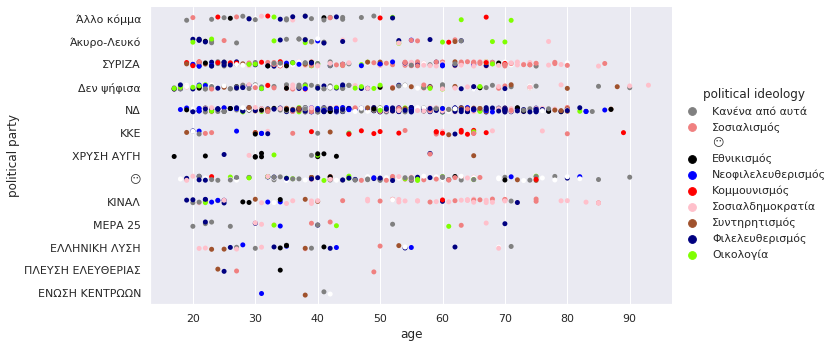

<Figure size 432x288 with 0 Axes>

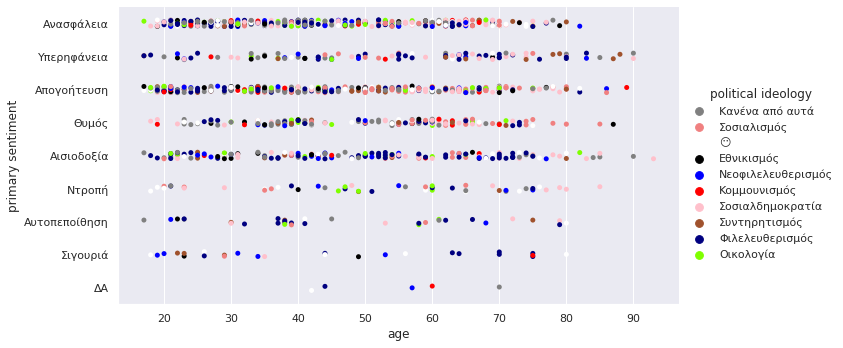

<Figure size 432x288 with 0 Axes>

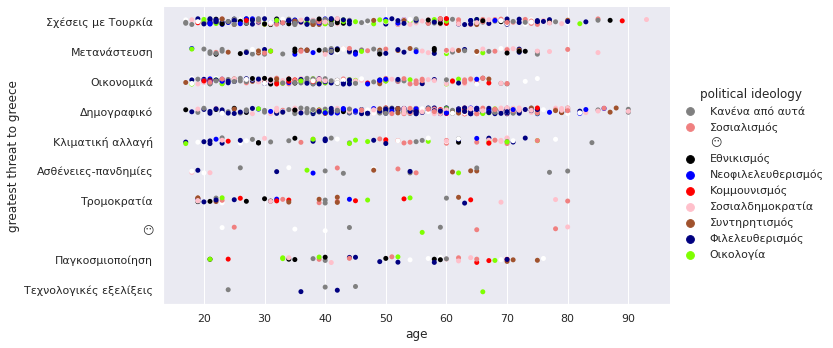

In [ ]:
sns.set()
palette={'Κανένα από αυτά': 'grey', 'Σοσιαλισμός': 'lightcoral', None: 'grey', 'Εθνικισμός': 'black', 'Νεοφιλελευθερισμός': 'blue', 'Κομμουνισμός': 'red', 'Σοσιαλδημοκρατία': 'pink', 'Συντηρητισμός': 'sienna', 'Φιλελευθερισμός': 'navy', 'Οικολογία': 'chartreuse','😶':'white'}
sns.catplot(data=data2,x='age',y='political party',hue='political ideology',palette=palette,height=5,aspect=2)
plt.figure()
sns.catplot(data=data2,x='age',y='primary sentiment',hue='political ideology',palette=palette,height=5,aspect=2)
plt.figure()
sns.catplot(data=data2,x='age',y='greatest threat to greece',hue='political ideology',palette=palette,height=5,aspect=2)

Not a very useful visualization. All one can tell by a glance is the relative popularity of each option by the number of points. There's also some dominance of specific colors over others for a couple of parties, but not nearly to the extent one would think.

Next, we'll use violin plots to map the popularity each of the columns by age, while the widths of the violins will be relative to the popularity of the answer.

In [ ]:
order=dict()
order['primary sentiment']=reversed(['😶', 'Ντροπή', 'Ανασφάλεια', 'Απογοήτευση', 'Θυμός', 'Αισιοδοξία', 'Αυτοπεποίθηση', 'Σιγουριά', 'Υπερηφάνεια'])
order['monthly family income']=reversed(['< 500€', '501-1.000€', '1.001-1.500€', '1.501-2.000€', '2.001-3.000€', '3.001-5.000€', '> 5.000€'])
order['approval of EU']=['😃', '☺', '😶', '☹', '😣']
order['greatest threat to greece']=['Τεχνολογικές εξελίξεις', 'Ασθένειες-πανδημίες', 'Κλιματική αλλαγή', 'Οικονομικά', 'Μετανάστευση', 'Σχέσεις με Τουρκία', 'Δημογραφικό', 'Παγκοσμιοποίηση', '😶']
order['greatest threat to world']=['Τεχνολογικές εξελίξεις', 'Ασθένειες - πανδημίες', 'Κλιματική αλλαγή', 'Οικονομικά', 'Μετανάστευση', 'Πόλεμοι & συγκρούσεις', 'Εξάντληση φυσικών πόρων', 'Τρομοκρατία', '😶']
order['lack of worry about climate']=['😃', '☺', '😶', '☹', '😣']
order['approval of covid vaccine']=['😃', '☺', '😶', '☹', '😣']
order['approval of immigrants']=['😃', '☺', '😶', '☹', '😣']
order['approval of same sex adoption']=['😃', '☺', '😶', '☹', '😣']
order['approval of gender change']=['😃', '☺', '😶', '☹', '😣']
order['approval of death penalty']=['😃', '☺', '😶', '☹', '😣']
order['religiosity']=['😇','😈']
order['political ideology']=['Κομμουνισμός', 'Σοσιαλισμός', 'Σοσιαλδημοκρατία', 'Οικολογία', 'Νεοφιλελευθερισμός', 'Φιλελευθερισμός', 'Συντηρητισμός', 'Εθνικισμός', 'Κανένα από αυτά', '😶']
order['political party']=['ΚΚΕ', 'ΜΕΡΑ 25', 'ΠΛΕΥΣΗ ΕΛΕΥΘΕΡΙΑΣ', 'ΚΙΝΑΛ', 'ΣΥΡΙΖΑ', 'ΕΝΩΣΗ ΚΕΝΤΡΩΩΝ', 'ΝΔ', 'ΕΛΛΗΝΙΚΗ ΛΥΣΗ', 'ΧΡΥΣΗ ΑΥΓΗ', 'Άλλο κόμμα', 'Άκυρο-Λευκό', 'Δεν ψήφισα', '😶']

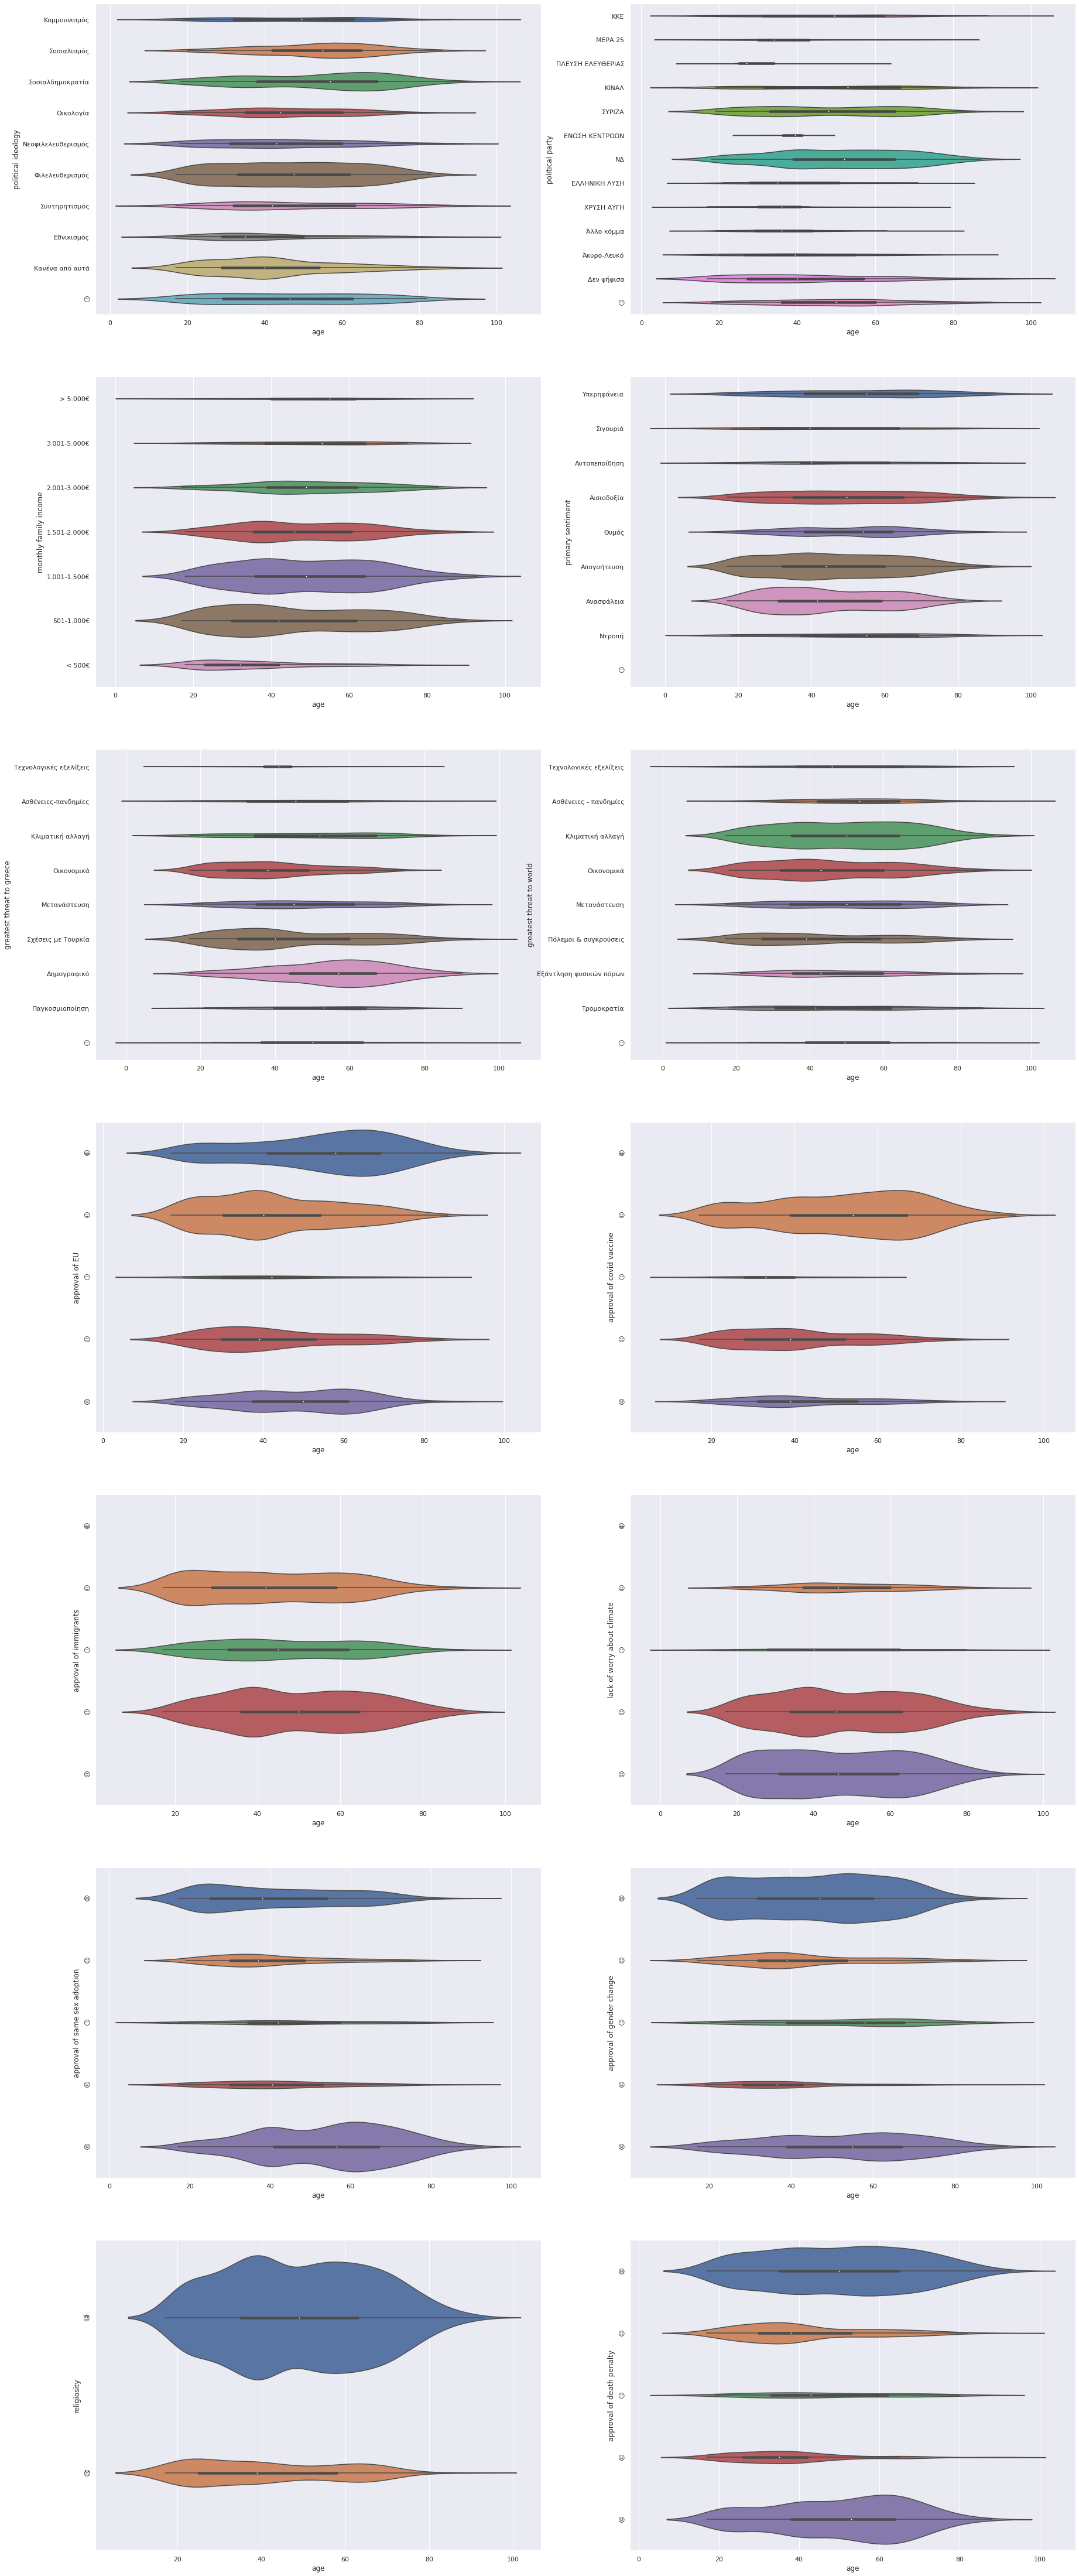

In [ ]:
sns.set()
column=(c for c in data2.columns if c!='age')
fig, axes = plt.subplots(7, 2, figsize=(30,80))
for i in range(7):
    for j in range(2):
        c=next(column)
        sns.violinplot(data=data2, x='age', y=c, ax=axes[i,j], scale='count', order=order[c])

Quite interesting! There are a few things that jump out immediately, such as the fact that younger people (mainly between 20 and 50) are more likely to not identify with a political ideology and to not have voted, that younger people believe Greece is mostly threatened by economic hardship and its relationship with Turkey while older people are massively more worried about its declining population, or that older people (50 and above) are vastly more likely to believe that entering the EU has had an overall good outcome for Greece.

Younger people are also more likely to be distrustful of the Covid vaccine, to approve of adoption for same-sex couples and to not believe in god, though in all three cases, for better or worse, the majority opinion tends to be the adverse for nearly all ages.

We can also see a few polarising issues that our society is quite split on, like the restoration of the death penalty or the belief that refugees are an overall good, the latter seeing a proportionately massive amount of responders who refused to give an opinion.



We can also use the violinplot's split attribute in order to visualize the difference in age distributions for a binary variable, such as belief in god (unlike the above, these plots are not to scale):

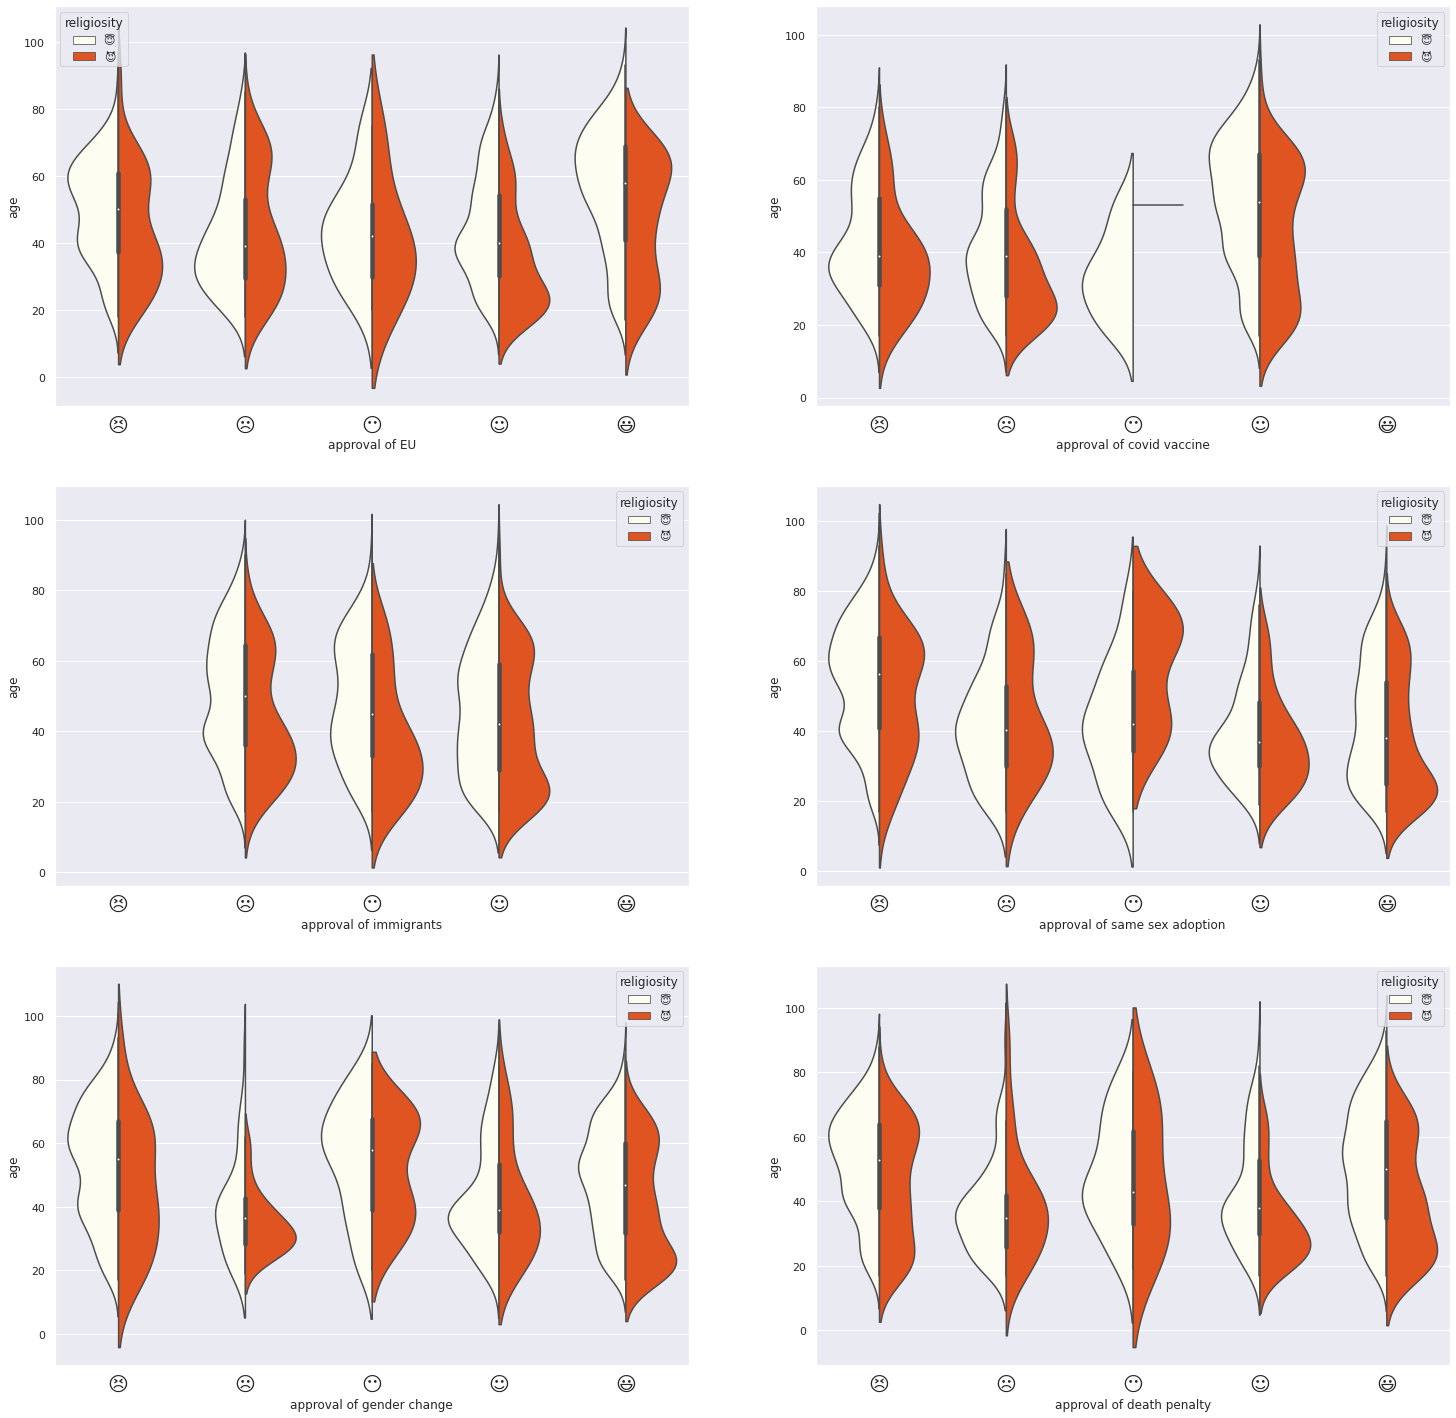

In [ ]:
sns.set()
plt.rcParams.update({'xtick.labelsize':20})

column=(c for c in ['approval of EU', 'approval of covid vaccine', 'approval of immigrants', 'approval of same sex adoption', 'approval of gender change', 'approval of death penalty'])
fig, axes = plt.subplots(3, 2, figsize=(25,25))
for i in range(3):
    for j in range(2):
        sns.violinplot(data=data2, y='age', x=next(column), hue='religiosity', split=True, order=['😣','☹','😶','☺','😃'], palette={'😇':'ivory','😈':'orangered'}, ax=axes[i,j])

plt.rcParams.update({'xtick.labelsize':10})

Now, let's move to something more quantifiable and see the distribution of all respondents per political party affiliation and ideology:

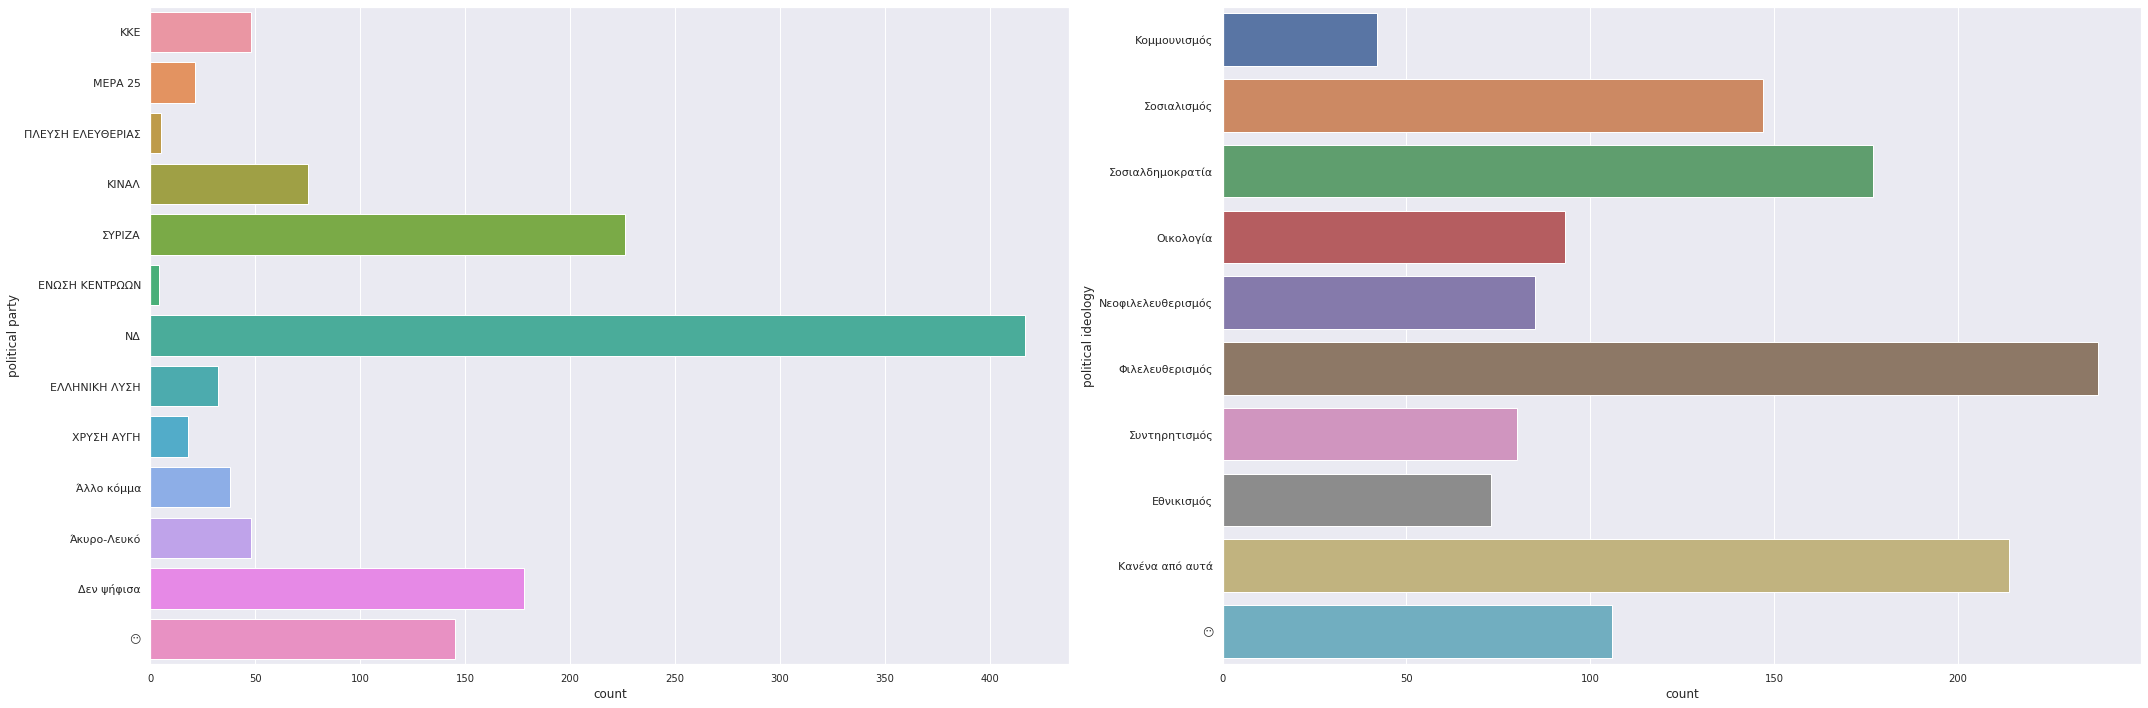

In [ ]:
plt.figure(figsize=(30,10),tight_layout=True)

plt.subplot(121)
sns.countplot(data=data2,y='political party', order=order['political party'])
plt.subplot(122)
sns.countplot(data=data2,y='political ideology', order=order['political ideology'])

We can see once more that while Greeks identify with all sorts of different ideologies, by the time they reach the ballot box they are mostly funneled into the top two or three major parties. A result of a voting system which trades individual expression and representation for political stability by favouring the established winners.

There is another thing that is worth noting however:

In [ ]:
data2['political party'].value_counts().apply(lambda x: 100*x/len(data)).sort_values(ascending=False)

ΝΔ                   33.227092
ΣΥΡΙΖΑ               18.007968
Δεν ψήφισα           14.183267
😶                    11.553785
ΚΙΝΑΛ                 5.976096
Άκυρο-Λευκό           3.824701
ΚΚΕ                   3.824701
Άλλο κόμμα            3.027888
ΕΛΛΗΝΙΚΗ ΛΥΣΗ         2.549801
ΜΕΡΑ 25               1.673307
ΧΡΥΣΗ ΑΥΓΗ            1.434263
ΠΛΕΥΣΗ ΕΛΕΥΘΕΡΙΑΣ     0.398406
ΕΝΩΣΗ ΚΕΝΤΡΩΩΝ        0.318725
Name: political party, dtype: float64

In [ ]:
voted=data2['political party'][~data2['political party'].isin(['Δεν ψήφισα','😶'])]
voted.value_counts().apply(lambda x: 100*x/len(voted)).sort_values(ascending=False)

ΝΔ                   44.742489
ΣΥΡΙΖΑ               24.248927
ΚΙΝΑΛ                 8.047210
Άκυρο-Λευκό           5.150215
ΚΚΕ                   5.150215
Άλλο κόμμα            4.077253
ΕΛΛΗΝΙΚΗ ΛΥΣΗ         3.433476
ΜΕΡΑ 25               2.253219
ΧΡΥΣΗ ΑΥΓΗ            1.931330
ΠΛΕΥΣΗ ΕΛΕΥΘΕΡΙΑΣ     0.536481
ΕΝΩΣΗ ΚΕΝΤΡΩΩΝ        0.429185
Name: political party, dtype: float64

At 33% of the total poll respondents and 44% of the admitted-to votes, the percentage of people who voted for the New Democracy party is considerably above the [actual results](https://ekloges.ypes.gr/current/v/home/) of the 2019 elections, and the rest of the parties are similarly below their expected values, with Syriza and Mera25 suffering the most.

Either the voters of those parties are particularly embarassed about their choice, or the organisation conducting the poll is not quite as independent and non-partisan as it claims.

Finally, we are going to use cross tabulation to examine more closely the relationship between pairs of quuestions (how many of those who answered A on question X answered B on question Y?).

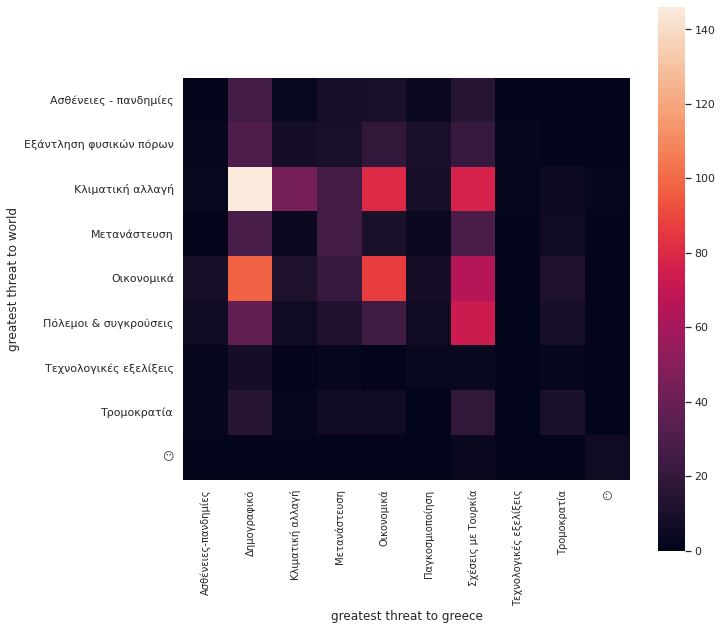

In [ ]:
plt.figure(figsize=(10,10))
data_crosstab = pd.crosstab(data2['greatest threat to world'], data2['greatest threat to greece'])
sns.heatmap(data_crosstab, square=True)

Above we can see the number of respondents in each bucket of 'threat to world'/'threat to greece' combination. We can see the most popular option for each question standing out by the rows/columns that are lit up, and the intersections between them. We can also see other relationships, such as the fact that not many people believe climate change is the #1 threat to Greece, but the ones who do are overwhelmingly more likely to believe it is the greatest threat to the world as well, or the fact that Turkey seems to be considered a lesser threat to Greece than demographics and the economy, except for people who also believe that wars are the primary threat to the world.

These relationships can also be viewed in a bar graph, less succinctly but more precisely.

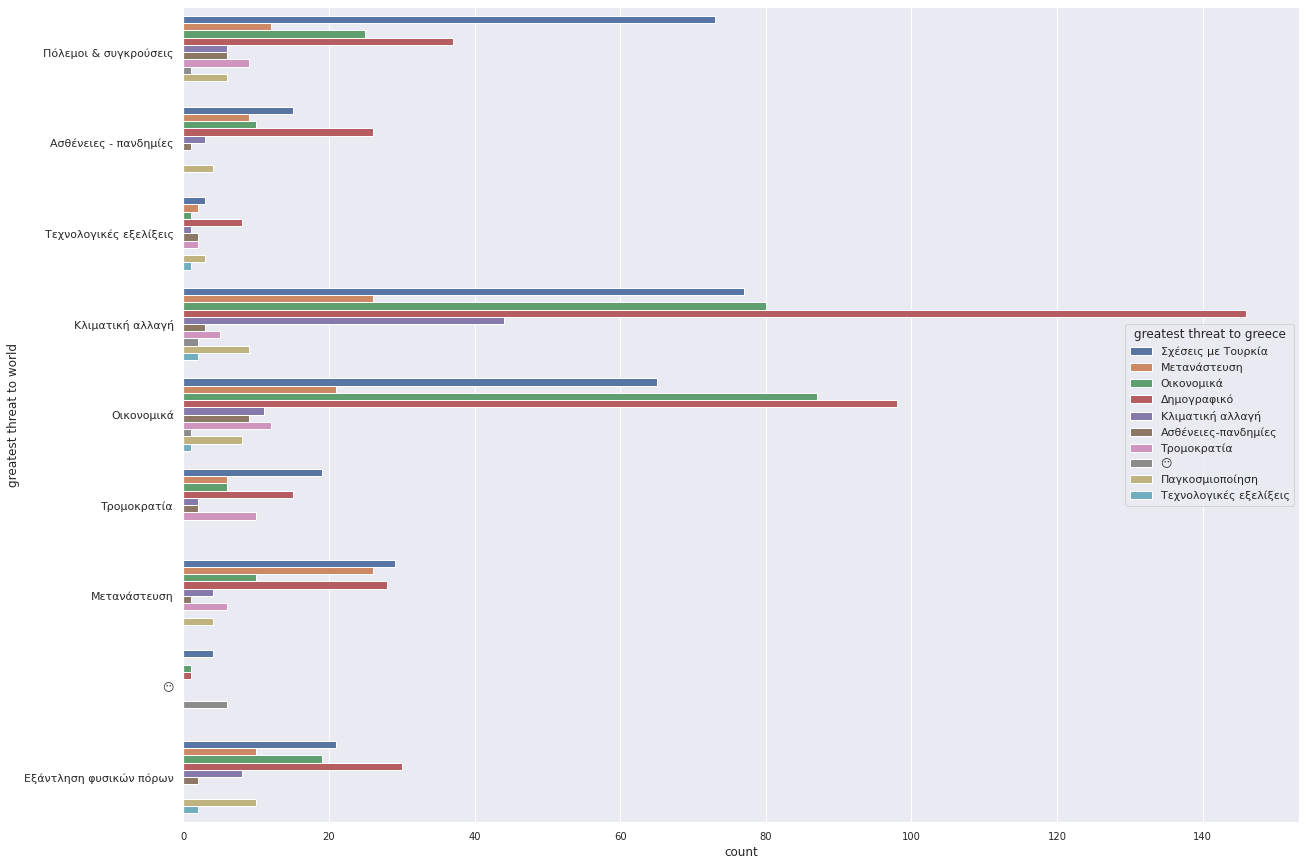

In [ ]:
plt.figure(figsize=(20,15))
sns.countplot(y='greatest threat to world', hue='greatest threat to greece', data=data2)

 Sometimes it is preferable to normalise over an axis so that less popular options are not completely invisible, such as the next plots which show the percentage, rather than absolute number, of responses per political ideology:

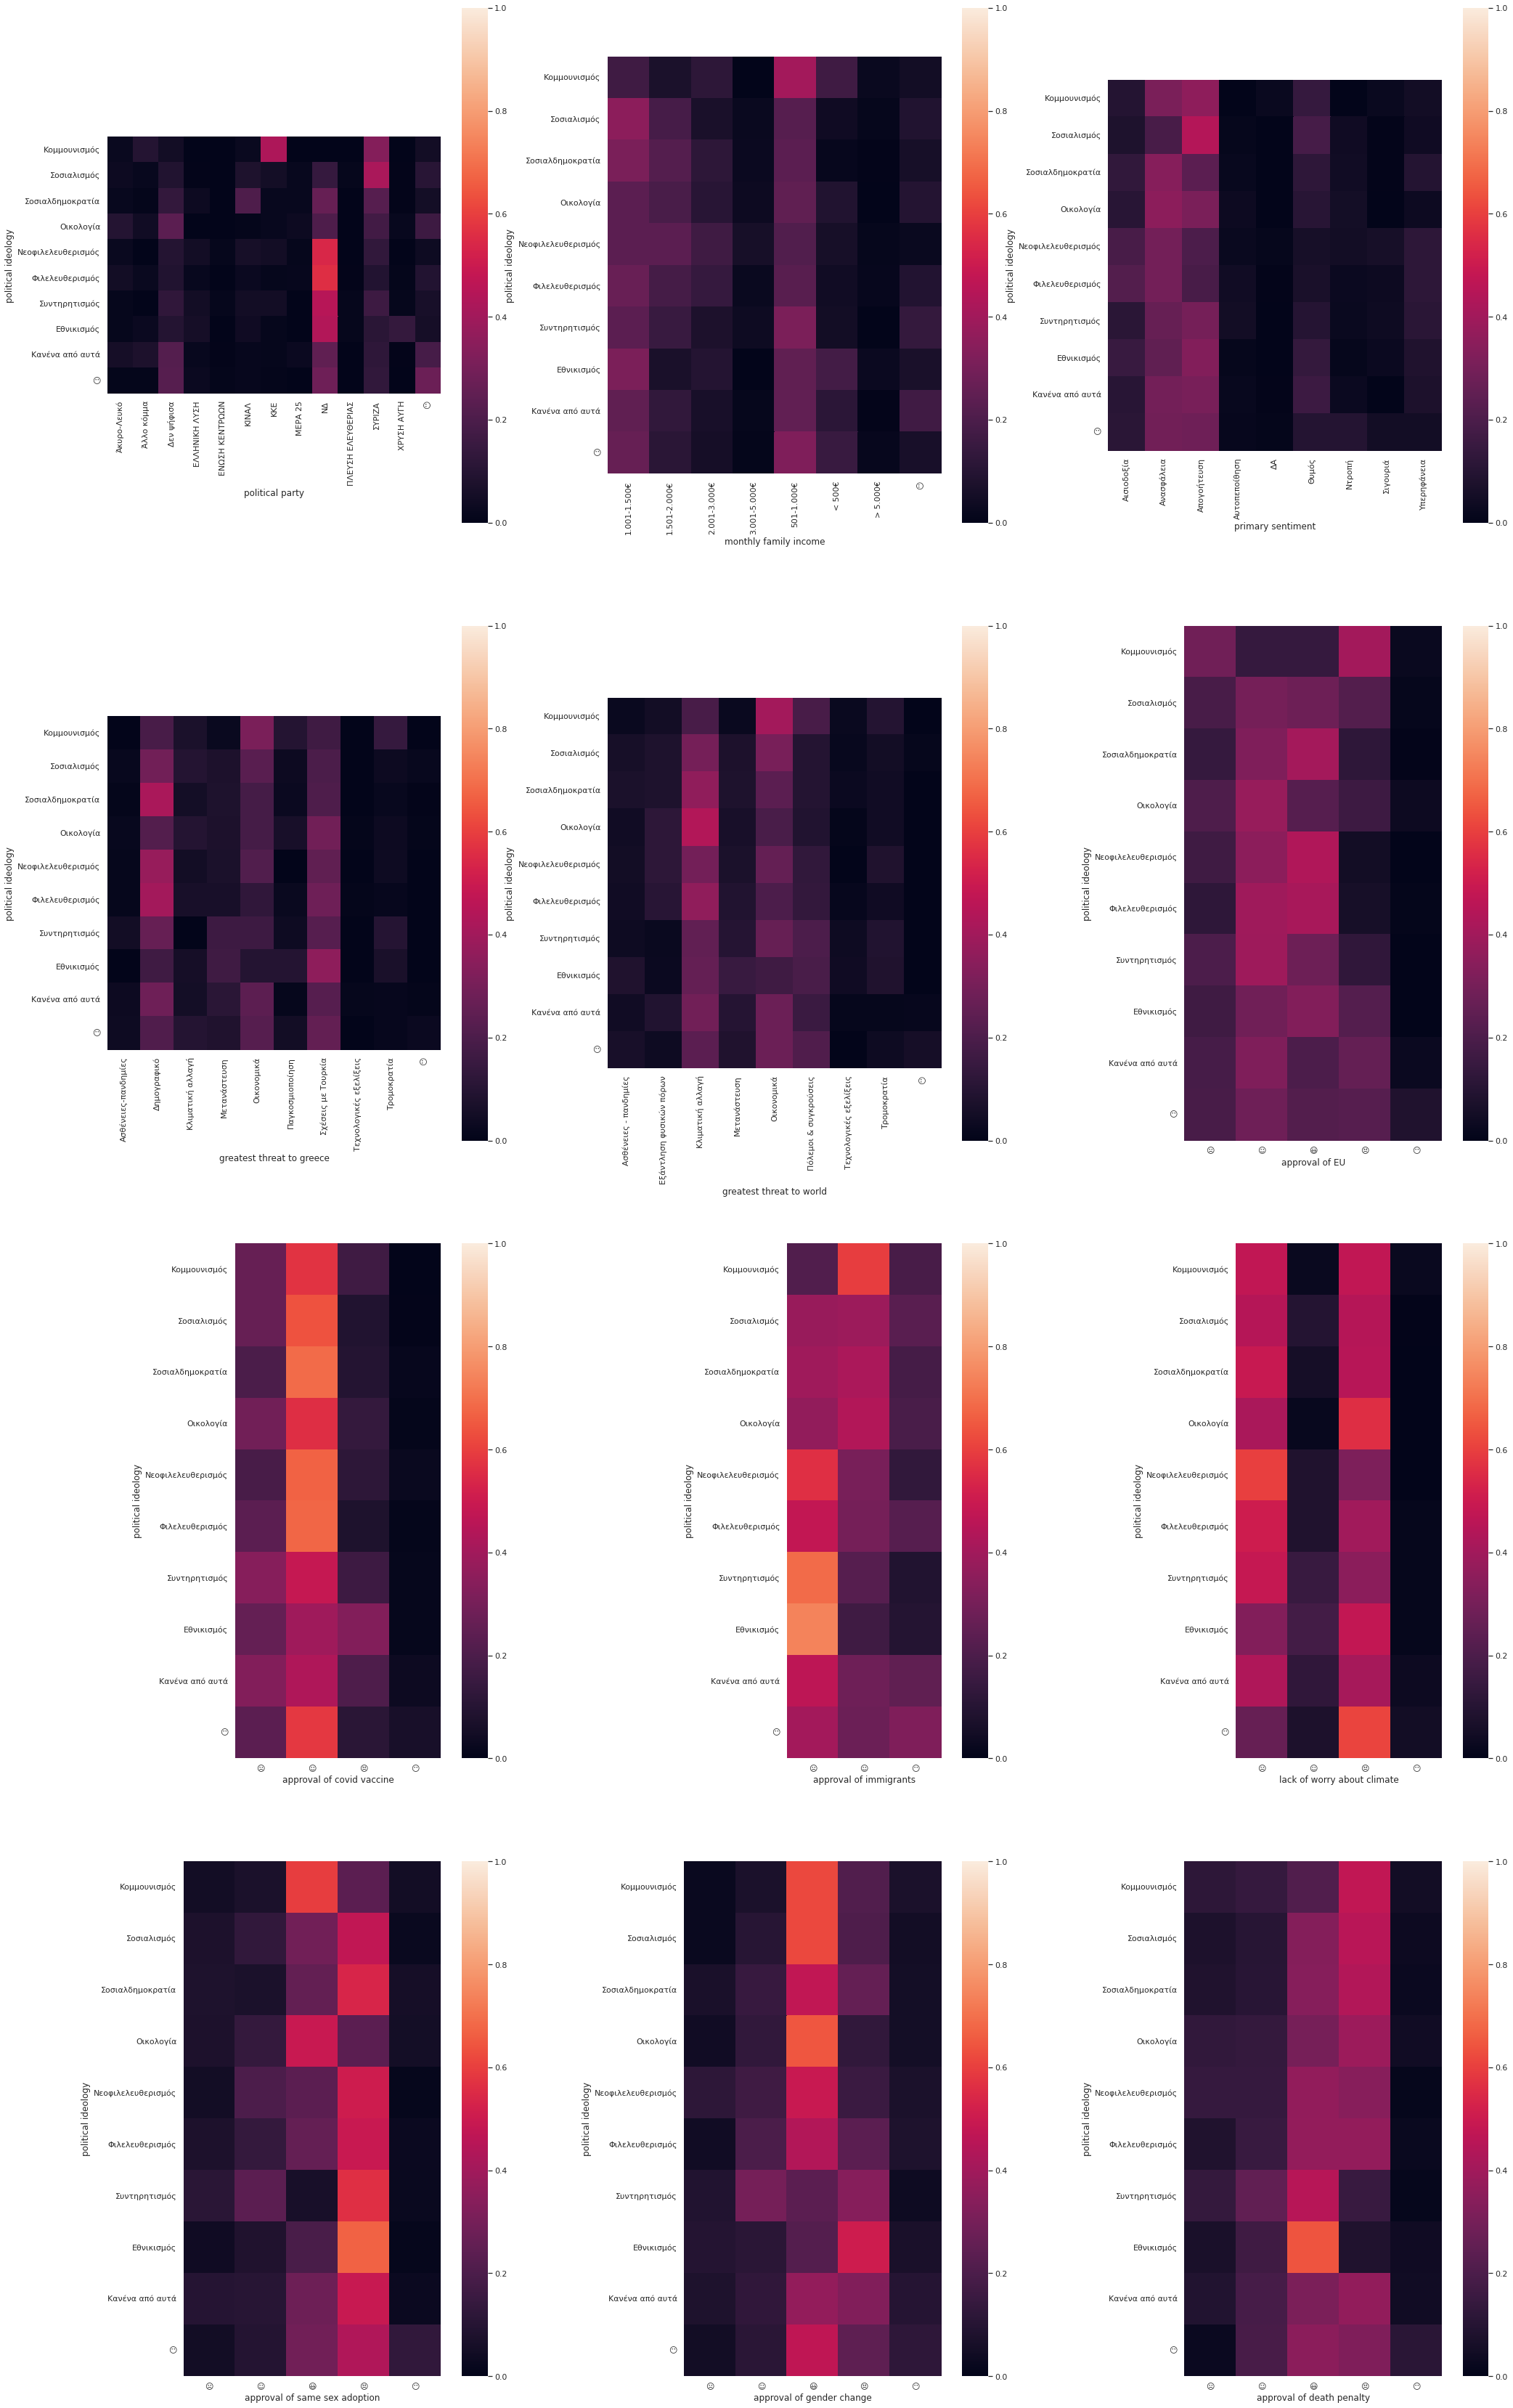

In [ ]:
sns.set()
column=(c for c in data2.columns if c not in ['age','political ideology','religiosity'])
fig, axes = plt.subplots(4, 3, figsize=(35,60))
for i in range(4):
    for j in range(3):
        c=next(column)
        data_crosstab = pd.crosstab(data2['political ideology'], data2[c], normalize='index')
        data_crosstab=data_crosstab.reindex(order['political ideology'])
        sns.heatmap(data_crosstab, square=True, ax=axes[i,j], vmin=0, vmax=1)

A lot can be seen from these plots as well. Communists and nationalists seem to be the most common ideologies to stick out compared to all the rest, and always in ways opposed to one another. Communists are most likely to approve of adoption by same sex couples, recognition of changed genders, and immigration while least likely to approve of the death penalty, with nationalists being the exact opposite. Nationalists are also less likely to be opinionated about the covid vaccine, the EU, what the greatest threat to the world might be, and climate change. After communists, people who identified as ecologists were next most likely to approve of adoption by same sex couples. After nationalists, conservatives were next most likely to approve of the return of the death penalty.

# Conclusion

Overall, though we've barely scraped the tip of the iceberg, there was plenty of insight to be gathered through this exploration.

We could see relationships between seemingly unrelated or even contradictory variables, such as religious people (presumably christians, as in 'love thy neighbour') being more hostile towards immigrants, foreigners and gender and sexual minorities.

We saw that most beliefs are only somewhat correlated with political ideology, but some are more polarizing between the left and the right, such as approval of immigrants.

We saw trends among the youth, such as increasing irreligiosity, lack of political affiliation, and decreasing trust for the EU.

And one thing that was perhaps most surprising was the broad popularity for the restoration of the death penalty. To end with a word of advice for the Greeks among us who might, perhaps in their 11.79% primary sentiment of anger, be tempted into agreeing with such a measure, I can only say: 'Some people deserve to die', even if accepted on face value, is not the same as 'the government should get to decide who lives and who dies'.